# Spectral Analysis

__Overview__: This lab is meant as an introduction to Spectral Analysis and the Fourier Transform.

__Goals__: Students should:

1. Be able to calculate the discrete Fourier transform using numpy.
2. Gain intuition for the discrete Fourier transform.
3. Gain intuition for how our signal reconstruction changes with more terms in the Fourier Series.
4. Be able to calculate the spectrogram of a signal using scipy.
5. Gain intuition for how we can use the spectogram to filter the signal.

In [2]:
import functools
from typing import Any, Tuple

import numpy as np
from matplotlib import colorbar
import matplotlib.pyplot as plt
import scipy.signal as scipy_signal

In [21]:
# Useful helper functions.
def compare_signal_plot(
    signal: np.ndarray, reconstructed_signal: np.ndarray, signal_name: str
):
    fontsize = 12
    fig, ax = plt.subplots(2, 1, figsize=(10, 5), dpi=100, sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})
    colors = ['#a1dab4', '#41b6c4', '#225ea8']
    
    ax[0].plot(time, signal, label=signal_name, color=colors[0])
    ax[0].plot(time, reconstructed_signal, label='Reconstructed Signal', color=colors[1])
    ax[0].set_ylabel('Signal', fontsize=fontsize)
    ax[0].legend(fontsize=fontsize, loc=1, framealpha=1.0)
    ax[0].set_ylim([-30,30])
    
    ax[1].plot(time, signal-reconstructed_signal, 
               label=f'{signal_name} - Reconstructed Signal', color=colors[1])
    plt.axhline(0, c='k')
    ax[1].set_ylabel('Error', fontsize=fontsize)
    ax[1].legend(fontsize=fontsize, loc=1, framealpha=1.0)
    ax[1].set_ylim([-10,10])
    ax[1].set_xlabel('Time', fontsize=fontsize)
    
    fig.subplots_adjust(hspace=0.0)
    plt.show()

## Periodic Signals
In this lab we'll be working with two periodic signals that will help us appreciate the Fourier Transform. The first will be the sawtooth function:

$$
X_t = t \text{ mod } P_\text{saw} - \frac{P_\text{saw}}{2}
$$
where $P_\text{saw}$ is the periodicity in our dataset. We will also use a sum of sines with time-varying amplitude:

$$
X_t = A_t \sin(2 \pi k_A t) + B_t \sin(2 \pi k_B t) + C_t \sin(2 \pi k_C t) 
$$
$$
A_t = c_A * \text{round}(\sin(2 \pi \frac{t}{P_A})) \ \ \ \ \text{or}  \ \ \ \  c_A
$$
$$
B_t = c_B * \text{round}(\sin(2 \pi \frac{t}{P_B})) \ \ \ \ \text{or}  \ \ \ \ c_B
$$
$$
C_t = c_C * \text{round}(\sin(2 \pi \frac{t}{P_A}))  \ \ \ \ \text{or}  \ \ \ \ c_C
$$
where we will set the time-varying amplitude to a sawtooth function or a constant value. Note that $k_A,k_B,$ and $k_C$ are the frequency of our oscillating signal, whereas $P_A,P_B,$ and $P_C$ are the period for our amplitudes, and $c_A, c_B,$ and $c_C$ are constant amplitudes. $\text{round}(\cdot,1)$ implies rounding the number.

The different signal are plotted below.

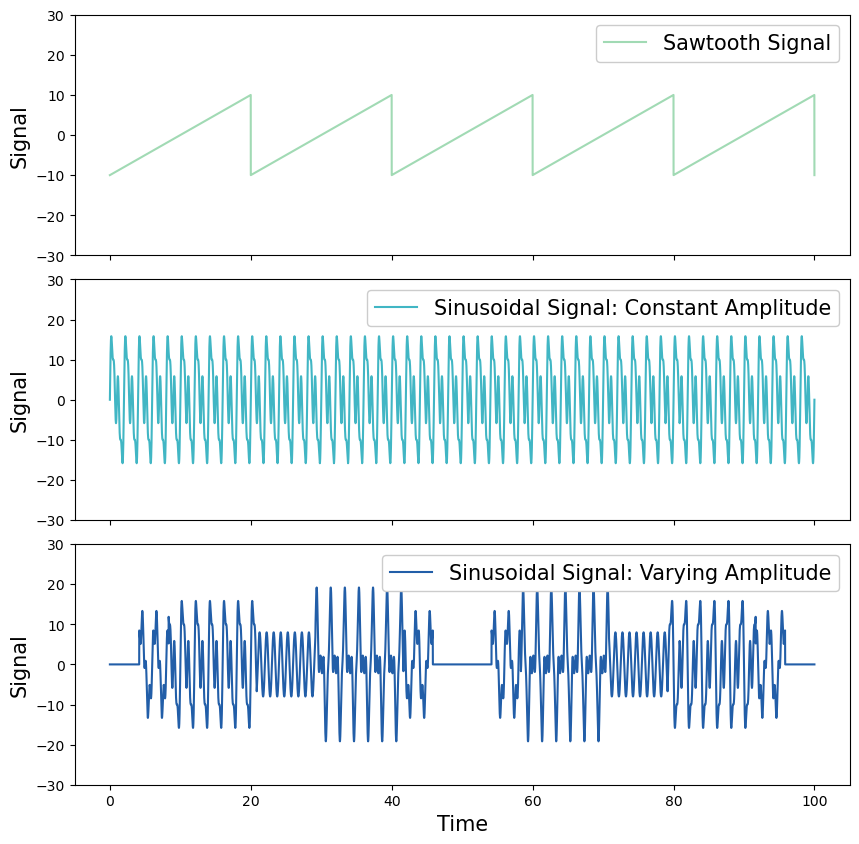

In [4]:
time = np.linspace(0,100,10000)
dt = np.max(time) / len(time)

############# Sawtooth function. #############
period_sawtooth = 20
sawtooth_signal = time % period_sawtooth - period_sawtooth / 2

############# Sine signal without amplitude variation. #############
# Frequency of the three components of the sine signal.
frequency_a = 1.0/2.0
frequency_b = 1.0/1.0
frequency_c = 2.0/1.0
# Constant amplitude of the sine functions.
c_a = 10.0
c_b = 8.0
c_c = 4.0
a_t_ntv = c_a
b_t_ntv = c_b
c_t_ntv = c_c
sines_ntv_signal = a_t_ntv * np.sin(2 * np.pi * frequency_a * time)
sines_ntv_signal += b_t_ntv * np.sin(2 * np.pi * frequency_b * time)
sines_ntv_signal += c_t_ntv * np.sin(2 * np.pi * frequency_c * time)

############# Sine signal with amplitude variation.  #############
# Period of the variation in the amplitude.
period_a = 50.0
period_b = 100.0
period_c = 50.0
a_t_tv = c_a * np.round(np.sin(2 * np.pi * time / period_a))
b_t_tv = c_b * np.round(np.sin(2 * np.pi * time / period_b))
c_t_tv = c_c * np.round(np.sin(2 * np.pi * time / period_c))
sines_tv_signal = a_t_tv * np.sin(2 * np.pi * frequency_a * time)
sines_tv_signal += b_t_tv * np.sin(2 * np.pi * frequency_b * time)
sines_tv_signal += c_t_tv * np.sin(2 * np.pi * frequency_c * time)

fontsize = 15
fig, ax = plt.subplots(3, 1, figsize=(10, 10), dpi=100, sharex=True)
colors = ['#a1dab4', '#41b6c4', '#225ea8']

ax[0].plot(time, sawtooth_signal, label='Sawtooth Signal', color=colors[0])
ax[0].set_ylabel('Signal', fontsize=fontsize)
ax[0].legend(fontsize=fontsize, loc=1, framealpha=1.0)
ax[0].set_ylim([-30,30])

ax[1].plot(time, sines_ntv_signal, label='Sinusoidal Signal: Constant Amplitude', color=colors[1])
ax[1].set_ylabel('Signal', fontsize=fontsize)
ax[1].legend(fontsize=fontsize, loc=1, framealpha=1.0)
ax[1].set_ylim([-30,30])

ax[2].plot(time, sines_tv_signal, label='Sinusoidal Signal: Varying Amplitude', color=colors[2])
ax[2].set_ylim([-30,30])
ax[2].set_ylabel('Signal', fontsize=fontsize)
ax[2].set_xlabel('Time', fontsize=fontsize)
ax[2].legend(fontsize=fontsize, loc=1, framealpha=1.0)

fig.subplots_adjust(hspace=0.1)

# Part I: Fourier Series Functions

Our goal is to understand the fourier series representation of these signals. We also want to get a better understanding for the discrete fourier transform and the short-time Fourier transform. To start we need to:

1. Implement a function that calculates the $A_n$ and $B_n$ coefficients of the Fourier series for our signal. We will take advantage of the numpy implementation of the discrete Fourier transform.
2. Implement a function that filters which elements of the Fourier series expansion are used. This is equivalent to representing the data as the sum of a handful of cosine functions at a specific set of frequencies.

In [5]:
def calculate_fourier_series(
    dt: float, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Calculate the Fourier series coefficients using the Fourier transform.

    Args:
        dt: Interval between samples.
        signal: Real signal at each point in time.

    Returns:
        Frequencies, A_n, and B_n coefficients for the fourier series 
        representaiton.

    Notes:
        Take advantage of numpy.fft. Remember that the signal is real not 
        complex. You may want to take advantage of the norm keyword.
    """
    # Placeholders.
    a_n = None
    b_n = None

    # TODO: Calculate the frequencies of each A_n and B_n. Remember that the
    # maximum frequency you can measure (and the maximum value numpy.fft will return
    # for real-valued signals) will be the Nyquist frequency.
    N = len(signal)
    frequencies = np.fft.rfftfreq(N, d=dt)   # TODO
    
    # TODO: Calculate the fourier series coefficients. Compare the equations from
    # the notes, and read the numpy.fft documentation carefully.
    fourier_transform = np.fft.rfft(signal)/N # TODO
    a_n = 2*fourier_transform.real
    b_n = -2*fourier_transform.imag

    return frequencies, a_n, b_n

def reconstructed_signal(
    frequency_mask: float, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return the signal with a mask applied to the Fourier series.

    Args:
        frequency_mask: Terms in the Fourier series to mask.
        signal: Real signal at each point in time.

    Returns:
        Reconstructed signal after frequency mask has been applied.

    Notes:
        Take advantage of numpy.fft. Remember that the signal is real not 
        complex.
    """    
    # TODO: Calculate the fourier transform, apply the mask,
    # and reverse the transformation.
    N = len(signal)

    # Step 2: Compute Fourier Transform using np.fft.rfft
    fourier_transform = np.fft.rfft(signal)  # Normalize by the number of samples
    masked_spectrum =  fourier_transform*frequency_mask
    # Reconstruct the signal
    reconstructed_signal = np.fft.irfft(masked_spectrum, n=N)
    return reconstructed_signal
    

In [6]:
# A few tests for our functions.
# Star with the calculate_fourier_series function.
test_signal = np.array([0.1, 0.2, 0.2, 0.1, 0.5])
f_t, a_n_t, b_n_t = calculate_fourier_series(0.2, test_signal)

# Test that the correct frequencies were extracted.
np.testing.assert_array_almost_equal(f_t, np.array([0.0, 1.0, 2.0]))

# Test that the correct frequencies were extracted.
np.testing.assert_array_almost_equal(a_n_t, np.array([ 0.44, 0.029443, -0.149443]))

# Test that the correct frequencies were extracted.
np.testing.assert_array_almost_equal(b_n_t, np.array([0.0, -0.090615, -0.108576]))

# Test masking
test_mask = [False, True, False]
recon_signal = reconstructed_signal(test_mask, test_signal)
np.testing.assert_array_almost_equal(recon_signal, np.array([0.029443, -0.077082, -0.077082,  0.029443,  0.095279]))

# Part II: Analyzing our Signals with a Fourier Series.

Let's start by visualizing the first 250 $A_n$ and $B_n$ coefficients for our sum of sines signal with constant amplitude. We know the input frequency of the data since we generated it, so we can add that to our plot.

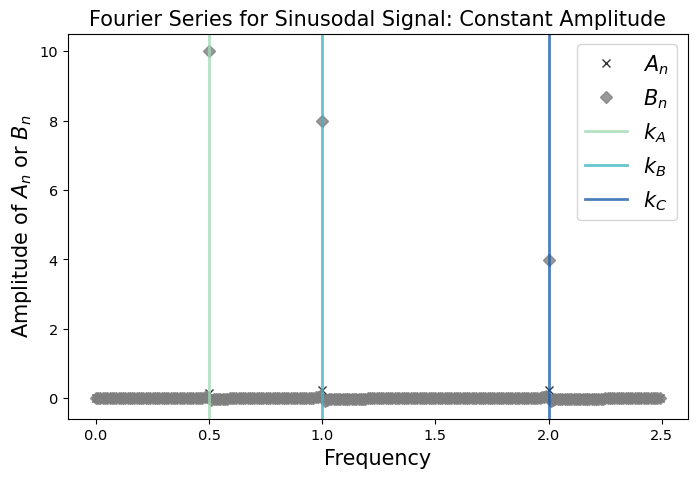

In [107]:
# TODO: Calculate the coefficients / frequencies and plot first 250 values.
frequencies, a_n_sntv, b_n_sntv = calculate_fourier_series(dt, sines_ntv_signal)
frequencies_to_plot = frequencies[:250]
a_n_to_plot = a_n_sntv[:250]
b_n_to_plot = b_n_sntv[:250]

plt.figure(figsize=(8,5), dpi=100)
colors = ['black','grey']
plt.plot(frequencies_to_plot, a_n_to_plot, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
plt.plot(frequencies_to_plot, b_n_to_plot, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.8)

colors_freq = ['#a1dab4', '#41b6c4', '#225ea8']
plt.axvline(frequency_a, label=r'$k_A$', color=colors_freq[0], lw=2, alpha=0.8)
plt.axvline(frequency_b, label=r'$k_B$', color=colors_freq[1], lw=2, alpha=0.8)
plt.axvline(frequency_c, label=r'$k_C$', color=colors_freq[2], lw=2, alpha=0.8)
plt.legend(fontsize=fontsize)
plt.ylabel(r'Amplitude of $A_n$ or $B_n$', fontsize=fontsize)
plt.xlabel('Frequency', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize * 0.7)
plt.title('Fourier Series for Sinusodal Signal: Constant Amplitude', fontsize=fontsize)
plt.show()

__Why do the $B_n$ values peak where they do?__

__Justify the specific values of $B_n$__

__Why are $A_n$ values so small?__

****
Becuase the generative process is composed of three sine functions of amplitude and ferquency pairs (10,0.5), (8,1), and (4,2). $A_n$ values are small because there are no cosine functions but only sine functions.
****

Let's repeat this excercise on our sawtooth signal. Let's visualizing the first 250 $A_n$ and $B_n$ coefficients. We know the input period of the data (and can take advantage of frequency = 1 / period), so we can add that to our plot.

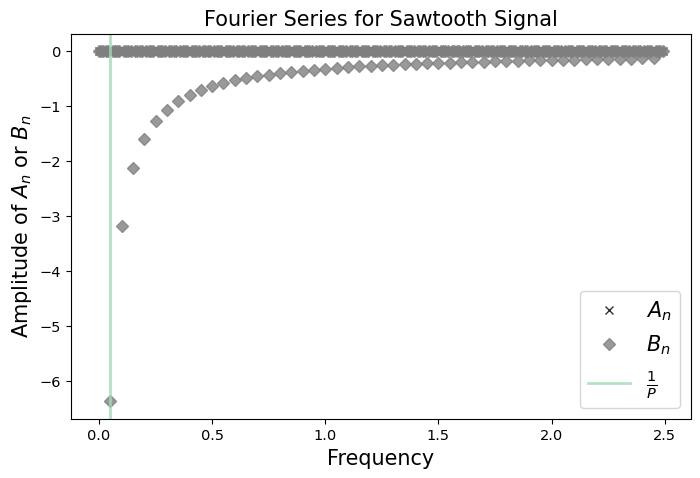

In [108]:
# TODO: Calculate the coefficients / frequencies and plot first 250 values.
frequencies, a_n_saw, b_n_saw = calculate_fourier_series(dt, sawtooth_signal)
frequencies_to_plot = frequencies[:250]
a_n_to_plot = a_n_saw[:250]
b_n_to_plot = b_n_saw[:250]

plt.figure(figsize=(8,5), dpi=100)
colors = ['black','grey']
plt.plot(frequencies_to_plot, a_n_to_plot, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
plt.plot(frequencies_to_plot, b_n_to_plot, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.8)

colors_freq = ['#a1dab4', '#41b6c4', '#225ea8']
plt.axvline(1/period_sawtooth, label=r'$\frac{1}{P}$', color=colors_freq[0], lw=2, alpha=0.8)
plt.legend(fontsize=fontsize)
plt.ylabel(r'Amplitude of $A_n$ or $B_n$', fontsize=fontsize)
plt.xlabel('Frequency', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize * 0.7)
plt.title('Fourier Series for Sawtooth Signal', fontsize=fontsize)
plt.show()

__Why is $B_n$ non-zero for so many different frequencies?__

****
Because the sawtooth functions has sharp changes that are not induced by either sine or cosine functions, and it requires much more functions to approximate.
****

Finally, let's repeat this excercise on our sum of sines signal with varying amplitude. Let's visualizing the first 250 $A_n$ and $B_n$ coefficients. We still know the input frequencies of our signal, so we can visualize those as well.

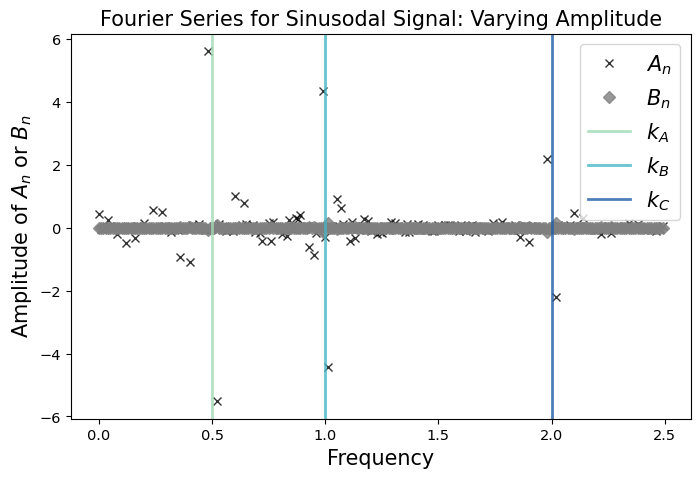

In [109]:
# TODO: Calculate the coefficients / frequencies and plot first 250 values.
frequencies, a_n_stv, b_n_stv = calculate_fourier_series(dt, sines_tv_signal)
frequencies_to_plot = frequencies[:250]
a_n_to_plot = a_n_stv[:250]
b_n_to_plot = b_n_stv[:250]

plt.figure(figsize=(8,5), dpi=100)
colors = ['black','grey']
plt.plot(frequencies_to_plot, a_n_to_plot, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
plt.plot(frequencies_to_plot, b_n_to_plot, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.8)

colors_freq = ['#a1dab4', '#41b6c4', '#225ea8']
plt.axvline(frequency_a, label=r'$k_A$', color=colors_freq[0], lw=2, alpha=0.8)
plt.axvline(frequency_b, label=r'$k_B$', color=colors_freq[1], lw=2, alpha=0.8)
plt.axvline(frequency_c, label=r'$k_C$', color=colors_freq[2], lw=2, alpha=0.8)
plt.legend(fontsize=fontsize)
plt.ylabel(r'Amplitude of $A_n$ or $B_n$', fontsize=fontsize)
plt.xlabel('Frequency', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize * 0.7)
plt.title('Fourier Series for Sinusodal Signal: Varying Amplitude', fontsize=fontsize)
plt.show()

__Why do the peaks in $B_n$ not line up with the input frequencies $k_A$, $k_B$, and $k_C$?__

****
Because the way we generate the signals are a bunch of sine functions and it has much less to do with cosine functions.
****

# Part III: Reconstructing our Signals with a Fourier Series.

Let's now try to reconstruct our signal using only a few terms in our Fourier series. Let's start with the data our Fourier series coefficients gave the simplest answer for: the sinusodal signal with constant amplitude. Mask out every frequency except $k_A$, $k_B$, and $k_C$.

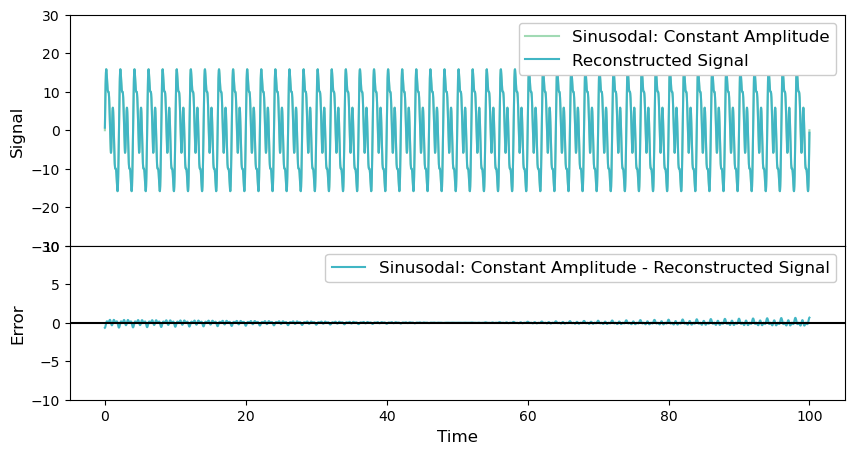

In [22]:
# TODO: Return the reconstructed signal using only frequencies frequency_a, frequency_b, and frequency_c.
mask = np.zeros(int(len(sines_ntv_signal)/2+1))
mask[np.where(frequencies == frequency_a)] = 1
mask[np.where(frequencies == frequency_b)] = 1
mask[np.where(frequencies == frequency_c)] = 1
reconstructed_sines_ntv_signal = reconstructed_signal(mask, sines_ntv_signal)

compare_signal_plot(sines_ntv_signal, reconstructed_sines_ntv_signal, 'Sinusodal: Constant Amplitude')

__Why is the reconstructed signal so accurate with only a few terms in our Fourier series?__

****
Because we use the exactly the parameters for the generation process. These three parameters are enough to describe the whole signal.
****

Let's try the same with our sawtooth signal. That is, let's only keep the Fourier series terms associated with the true frequency of the signal $\frac{1}{P_\text{saw}}$ and see how the reconstruction fares.

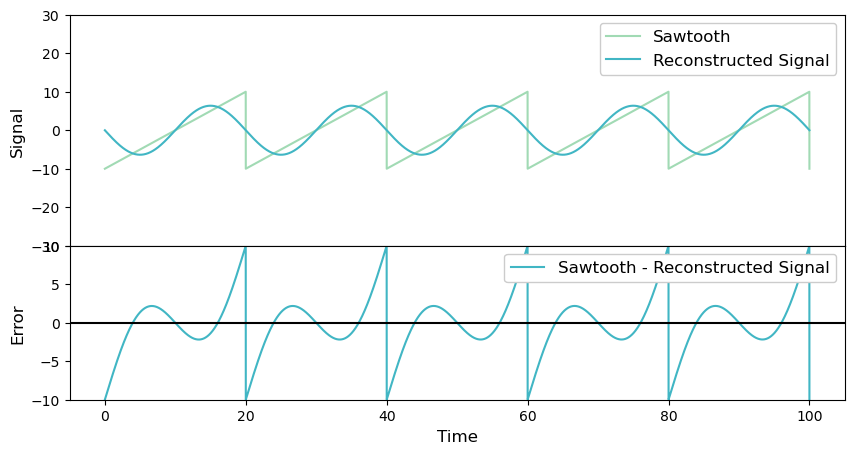

In [23]:
# TODO: Return the reconstructed signal using only frequencies frequency_a, frequency_b, and frequency_c.
mask = np.zeros(int(len(sawtooth_signal)/2+1))
mask[np.where(frequencies == 1/period_sawtooth)] = 1
reconstructed_sawtooth_signal = reconstructed_signal(mask, sawtooth_signal)

compare_signal_plot(sawtooth_signal, reconstructed_sawtooth_signal, 'Sawtooth')

__Why is the reconstruction so much poorer despite using the correct period?__

****
Because the sawtooth function is complicated and difficult to use only a few sine/cosine functions to approximate.
****

What if instead of using only the true periodicity of the signal, we use the twenty most important frequencies. Select the twenty frequencies for which $A_n^2 + B_n^2$ is the largest and reconstruct the signal.

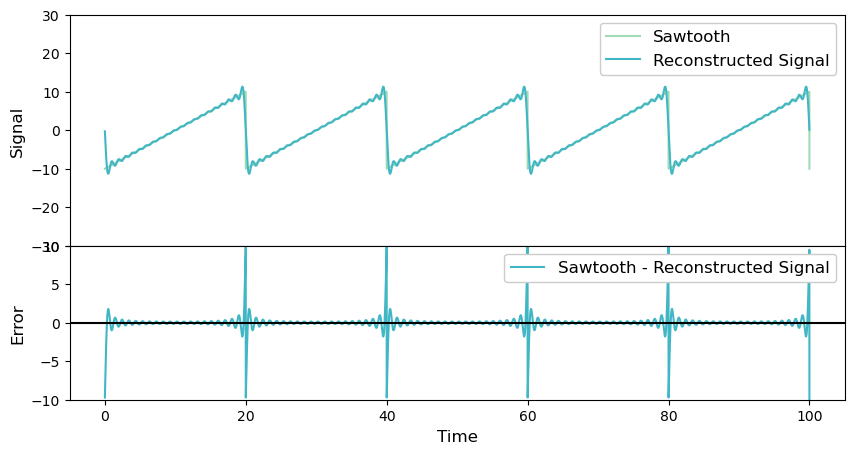

In [24]:
# TODO: Return the reconstructed signal using only frequencies frequency_a, frequency_b, and frequency_c.
mask = np.zeros(int(len(sawtooth_signal)/2+1))
frequencies, a_n_saw, b_n_saw = calculate_fourier_series(dt, sawtooth_signal)
magnitude = a_n_saw**2 + b_n_saw**2

# find the top 20 frequencies index
top_20_index = np.argsort(magnitude)[::-1][:20]
mask[top_20_index] = 1

reconstructed_sawtooth_signal = reconstructed_signal(mask, sawtooth_signal)

compare_signal_plot(sawtooth_signal, reconstructed_sawtooth_signal, 'Sawtooth')

__Given your answer to the last question, why does the reconstruction now look much better?__

****
Because we use more sine/cosine functions to approximate the difficult sawtooth function by providing a more complete view.
****

Let's return to the sinusodal signal with varying amplitude. Mask out every frequency except $k_A$, $k_B$, and $k_C$.

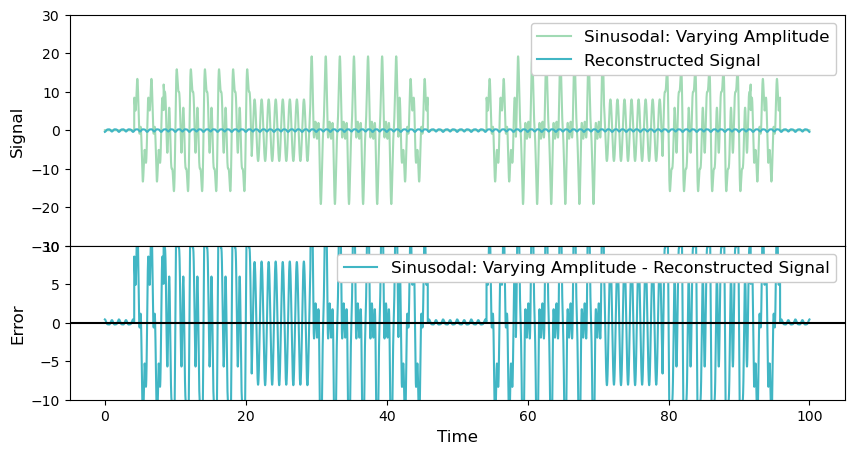

In [25]:
# TODO: Return the reconstructed signal using only frequencies frequency_a, frequency_b, and frequency_c.
mask = np.zeros(int(len(sines_tv_signal)/2+1))
mask[np.where(frequencies == frequency_a)] = 1
mask[np.where(frequencies == frequency_b)] = 1
mask[np.where(frequencies == frequency_c)] = 1
reconstructed_sines_tv_signal = reconstructed_signal(mask, sines_tv_signal)

compare_signal_plot(sines_tv_signal, reconstructed_sines_tv_signal, 'Sinusodal: Varying Amplitude')

__Why is this reconstruction so poor while the reconstruction for the constant amplitude signal was so accurate?__

****
Because the amplitudes of each sine functions are dynamically changing. Only using constant values fail to capture such dynamics.
****

What if we use the twenty most important frequencies again. Select the twenty frequencies for which $A_n^2 + B_n^2$ is the largest and reconstruct the signal.

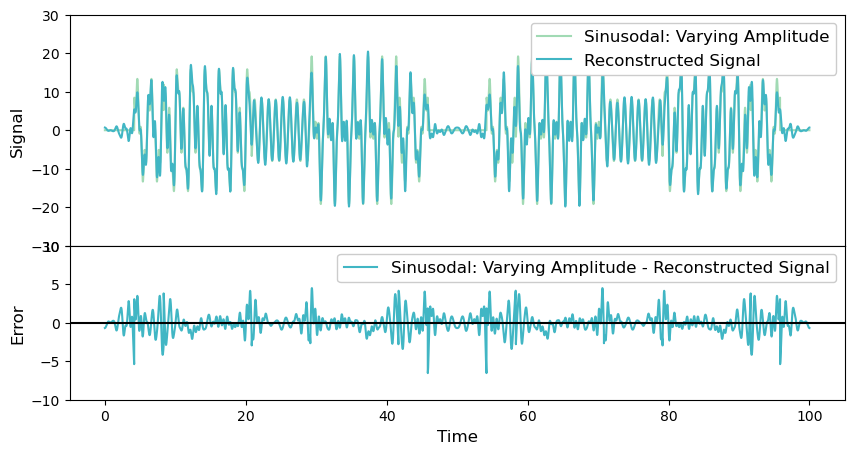

In [26]:
# TODO: Return the reconstructed signal using only frequencies frequency_a, frequency_b, and frequency_c.
mask = np.zeros(int(len(sines_tv_signal)/2+1))
frequencies, a_n_stv, b_n_stv = calculate_fourier_series(dt, sines_tv_signal)
magnitude = a_n_stv**2 + b_n_stv**2

# find the top 20 frequencies index
top_20_index = np.argsort(magnitude)[::-1][:20]
mask[top_20_index] = 1
reconstructed_sines_tv_signal = reconstructed_signal(mask, sines_tv_signal)

compare_signal_plot(sines_tv_signal, reconstructed_sines_tv_signal, 'Sinusodal: Varying Amplitude')

__Given your answer to the last question, why does the reconstruction now look much better?__

****
Similarly, by using more sine/cosine functions, we now improve the reconstruction by incorporating more representative components.
****

# Part IV: Dealing with Time-Varying Amplitudes

It should be possible to describe the sinusodal signal with time-varying amplitudes well using only the Fourier series terms with frequencies $k_A$, $k_B$, and $k_C$. Let's take advantage of the short-time Fourier transform to do this. First we will need to:
1. Implement a function that calculates the $A_{n,t}$ and $B_{n,t}$ coefficients of the Fourier series for our signal. We will take advantage of the scipy implementation of the short-time Fourier transform.
2. Implement a function that filters which elements of the Fourier series expansion are used. This will be similar to the previous function, but now for the short-time Fourier transform

__We've loaded scipy.signal as__ _scipy_signal_ __for you__

In [62]:
def calculate_time_varying_fourier_series(
    dt: float, n_steps_per_seg: int, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculate the Fourier series coefficients in multiple segments.

    Args:
        dt: Interval between samples.
        n_steps_per_seg: Number of time steps in each segment.
        signal: Real signal at each point in time.

    Returns:
        Frequencies, A_n and B_n coefficients for the fourier series 
        representaiton.

    Notes:
        Take advantage of scipy.signal.stft. You will want to use a boxcar
        window and ensure no overlap between the windows. Check the stft
        documentation for hints.
    """
    # Placeholders.
    a_n_t = None
    b_n_t = None
    frequencies = None
    time_segments = None

    N = len(signal)
    
    # TODO: Calculate the Fourier series coefficients for each segment. Remember 
    # to use a boxcar window and set the overlap to zero.
    frequencies, time_segments, fourier_segments = scipy_signal.stft(signal, fs=1/dt,window="boxcar", nperseg=n_steps_per_seg, noverlap=0)
    a_n_t = 2*fourier_segments.real
    b_n_t = -2*fourier_segments.imag

    return frequencies, time_segments, a_n_t, b_n_t

def reconstructed_time_varying_signal(
    frequency_mask: np.ndarray, dt: float, n_steps_per_seg: int, signal: np.ndarray
) -> Tuple[np.ndarray]:
    """Return the signal with a mask applied to the short-time Fourier series.

    Args:
        frequency_mask: Terms in the Fourier series to mask.
        dt: Interval between samples.
        n_steps_per_seg: Number of time steps in each segment.
        signal: Real signal at each point in time.

    Returns:
        Signal after frequency mask has been applied.

    Notes:
        Take advantage of scipy.signal.stft and scipy.signal.istft. Remember
        to use the boxcar window and no overlap.
    """    
    frequency_mask = frequency_mask[:, np.newaxis]

    frequencies, time_segments, a_n_t, b_n_t = calculate_time_varying_fourier_series(dt, n_steps_per_seg, signal)

    masked_a_n = a_n_t*frequency_mask/2
    masked_b_n = b_n_t*frequency_mask/2

    # Placeholder
    stft_reconstruction = scipy_signal.istft(masked_a_n + 1j*masked_b_n, fs=1/dt, window='boxcar', nperseg=n_steps_per_seg, noverlap=0)[1]
    
    # TODO: Calculate the fourier transform, apply the mask,
    # and reverse the transformation. You will need to add a
    # new axis to the mask.
    # raise ValueError('Write the code')
    return stft_reconstruction
    

In [63]:
# A few tests for our functions.
# Star with the calculate_fourier_series function.
test_signal = np.array([0.1, 0.2, 0.2, 0.1])
f_t, t_t, a_n_t, b_n_t = calculate_time_varying_fourier_series(0.2, 2, test_signal)

# Test that the correct frequencies were extracted.
np.testing.assert_array_almost_equal(f_t, np.array([0.0, 2.5]))

# Test that the correct times were extracted.
np.testing.assert_array_almost_equal(t_t, np.array([0.0, 0.4, 0.8]))

# Test that the correct frequencies were extracted.
np.testing.assert_array_almost_equal(
    a_n_t, 
    np.array([[0.1, 0.4, 0.1],[-0.1, 0.0, 0.1]])
)

# Test that the correct frequencies were extracted.
np.testing.assert_array_almost_equal(
    b_n_t, 
    np.array([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0]])
)

t_recon = reconstructed_time_varying_signal(
    np.array([0,1]), 0.2, 2, test_signal
)
np.testing.assert_array_almost_equal(
    t_recon, 
    np.array([0.05, 0.  , 0.  , 0.05])
)

Let's start by using our new functions to compare the $B_n$ and $A_n$ values for our sinusodal signal with constant amplitude.

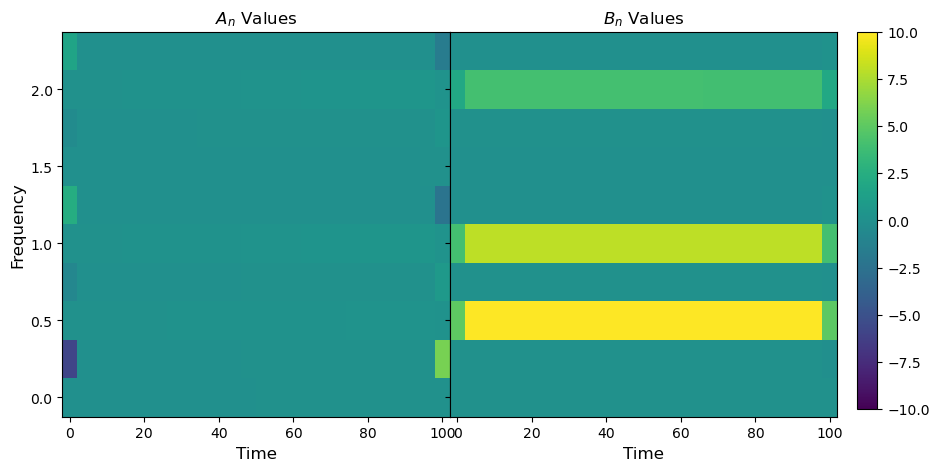

In [64]:
n_steps_per_seg = 400
frequencies, time_segments, a_n_t, b_n_t = calculate_time_varying_fourier_series(dt, n_steps_per_seg, sines_ntv_signal)

fontsize = 12
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100, sharey=True)

ax[0].pcolormesh(time_segments, frequencies[:10], a_n_t[:10], vmin=-10, vmax=10)
ax[0].set_title(r'$A_n$ Values', fontsize=fontsize)
ax[0].set_ylabel('Frequency', fontsize=fontsize)
ax[0].set_xlabel('Time', fontsize=fontsize)
pcm = ax[1].pcolormesh(time_segments, frequencies[:10], b_n_t[:10], vmin=-10, vmax=10)
ax[1].set_title(r'$B_n$ Values', fontsize=fontsize)
ax[1].set_xlabel('Time', fontsize=fontsize)


cbar_ax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
fig.colorbar(pcm, cax=cbar_ax)
fig.subplots_adjust(wspace=0.0)
plt.show()

__Do the $B_n$ values make sense? Why?__

****
Yes, because from the plot, we can infer that there are three components: when frequency is 0.5, the amplitude is 10, when frequency is 1, the amplitude is 8; when the frequency is 2, the amplitude is 4.
****

Now let's use our functions for what we intended: the sinusodal signal with varying amplitude.

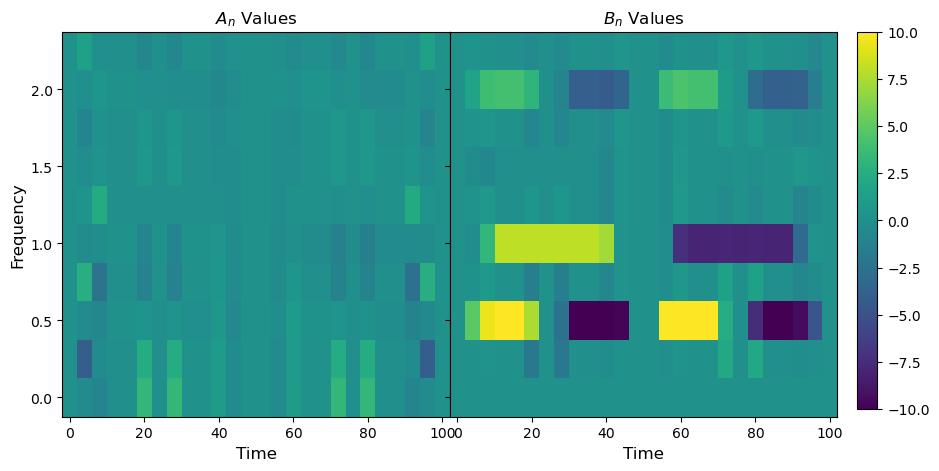

In [65]:
n_steps_per_seg = 400
frequencies, time_segments, a_n_t, b_n_t = calculate_time_varying_fourier_series(dt, n_steps_per_seg, sines_tv_signal)

fontsize = 12
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100, sharey=True)

ax[0].pcolormesh(time_segments, frequencies[:10], a_n_t[:10], vmin=-10, vmax=10)
ax[0].set_title(r'$A_n$ Values', fontsize=fontsize)
ax[0].set_ylabel('Frequency', fontsize=fontsize)
ax[0].set_xlabel('Time', fontsize=fontsize)
pcm = ax[1].pcolormesh(time_segments, frequencies[:10], b_n_t[:10], vmin=-10, vmax=10)
ax[1].set_title(r'$B_n$ Values', fontsize=fontsize)
ax[1].set_xlabel('Time', fontsize=fontsize)


cbar_ax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
fig.colorbar(pcm, cax=cbar_ax)
fig.subplots_adjust(wspace=0.0)
plt.show()

__Do the $B_n$ values capture the time variation?__

****
Yes, they do. We can observe that with the same frequency, the amplitude can goes from positive to negative with the values of 10, 8, 4.
****

Before we got a terrible reconstruction for our sinusodal signal with varying amplitude using only the target frequencies. Let's repeat that excercise with our short-time fourier transform and see how we do.

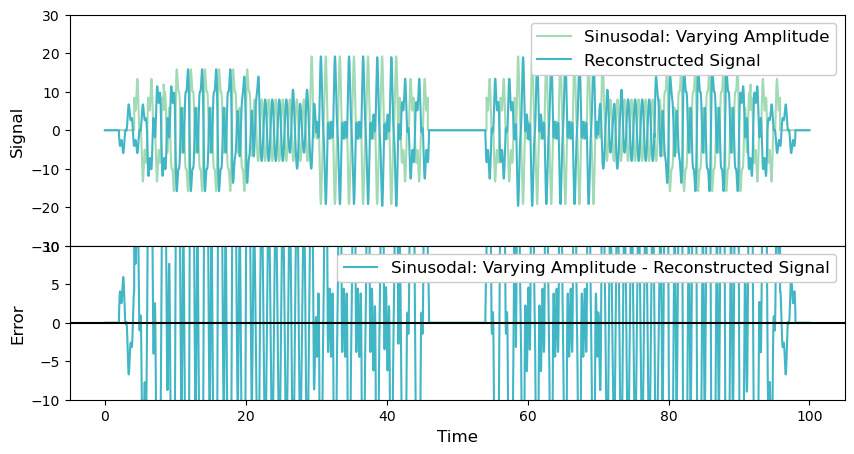

In [72]:
# TODO: Reconstruct the signal only using the three frequencies of the sines used to make the signal.
n_steps_per_seg = 400
frequencies, time_segments, a_n_t, b_n_t = calculate_time_varying_fourier_series(dt, n_steps_per_seg, sines_tv_signal)
mask = np.zeros(201)
mask[np.where(frequencies == frequency_a)] = 1
mask[np.where(frequencies == frequency_b)] = 1
mask[np.where(frequencies == frequency_c)] = 1
stft_reconstruction = reconstructed_time_varying_signal(mask, dt, n_steps_per_seg, sines_tv_signal)

compare_signal_plot(sines_tv_signal, stft_reconstruction, 'Sinusodal: Varying Amplitude')

__Why is the reconstruction so much better now?__

****
Although I don't think what I obtained is much better (because the residual is still large and maybe I did something wrong during the implementation), the graphics are indeed more aligned with ground truth signal in terms of trend and the magnitudes. The reason could be that now the $a_n$ and $b_n$ contain the temporal information, as shown in the previous plot.
****